# Practice PS07: Outlier analysis

Author: <font color="white">Mario Muñoz Serrano (U172951)</font>


Date: <font color="white">04/12/2022</font>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import io
import random
import numpy as np

# 1. Dataset

In [4]:
# LEAVE AS-IS

df = pd.read_csv('https://raw.githubusercontent.com/chatox/data-mining-course/master/practicum/data/annthyroid.csv', sep=',')

# Replace the "label" column by an "abnormal" column
df['result'] = df['label'].apply(lambda x: 'abnormal' if x == 1 else 'normal')
df.drop(columns=['label'], inplace=True)

In [5]:
# Total number of patients, 
# Number and percentage of patients with a normal thyroid
# Number and percentage of patients with an abnormal thyroid

# Computations
total = len(df)
t_normal = len(df[df['result'] == 'normal'])
t_abnormal = len(df[df['result'] == 'abnormal'])

p_normal   = round((t_normal/total)*100, 2)
p_abnormal = round((t_abnormal/total)*100, 2)

# Output
print(f"Total patients   : {total}\t")
print(f"Normal thyroid   : {t_normal}")
print(f"Abnormal thyroid : {t_abnormal}")
print(f"Percentage with normal thyroid    : {p_normal}")
print(f"Percentage with abnormal thyroid  : {p_abnormal}")

Total patients   : 7200	
Normal thyroid   : 6666
Abnormal thyroid : 534
Percentage with normal thyroid    : 92.58
Percentage with abnormal thyroid  : 7.42


In [6]:
# first 10 normal exams
df_normal = df[df['result'] == 'normal']
df_normal10 = df_normal.head(10)


print('First 10 normal exams')
df_normal10

First 10 normal exams


,f1,f2,f3,f4,f5,f6,result
0,0.73,0.00060,0.015,0.120,0.082,0.146,normal
1,0.24,0.00025,0.030,0.143,0.133,0.108,normal
2,0.47,0.00190,0.024,0.102,0.131,0.078,normal
3,0.64,0.00090,0.017,0.077,0.090,0.085,normal
4,0.23,0.00025,0.026,0.139,0.090,0.153,normal
5,0.69,0.00025,0.016,0.086,0.070,0.123,normal
6,0.85,0.00025,0.023,0.128,0.104,0.121,normal
7,0.48,0.00208,0.020,0.086,0.078,0.110,normal
8,0.67,0.00130,0.024,0.087,0.109,0.080,normal
9,0.76,0.00010,0.029,0.124,0.128,0.097,normal


In [7]:
# "centroid" (average) of a normal exam
print("Centroid  of a normal exam")
df_normal10.describe().loc[['mean']]

Centroid  of a normal exam


,f1,f2,f3,f4,f5,f6
mean,0.576,0.000788,0.0224,0.1092,0.1015,0.1101


In [8]:
# First 10 abnormal exams
df_abnormal = df[df['result'] == 'abnormal']
df_abnormal10 = df_abnormal.head(10)

print('First 10 abnormal exams')
df_abnormal10

First 10 abnormal exams


,f1,f2,f3,f4,f5,f6,result
10,0.62,0.01100,0.0080,0.0730,0.074,0.0980,abnormal
19,0.50,0.06100,0.0096,0.0130,0.116,0.0110,abnormal
27,0.78,0.02500,0.0090,0.0500,0.084,0.0600,abnormal
43,0.61,0.00979,0.0040,0.0810,0.064,0.1260,abnormal
84,0.56,0.00820,0.0200,0.0660,0.094,0.0700,abnormal
105,0.73,0.04700,0.0110,0.0520,0.090,0.0580,abnormal
115,0.43,0.07000,0.0050,0.0029,0.104,0.0028,abnormal
116,0.42,0.03100,0.0080,0.0130,0.119,0.0110,abnormal
145,0.78,0.00630,0.0110,0.0560,0.086,0.0650,abnormal
147,0.53,0.02500,0.0040,0.0390,0.061,0.0640,abnormal


In [9]:
# "centroid" (average) of a abnormal exam
print("Centroid  of a abnormal exam")
df_abnormal10.describe().loc[['mean']]

Centroid  of a abnormal exam


,f1,f2,f3,f4,f5,f6
mean,0.596,0.029429,0.00896,0.04459,0.0892,0.05658


In [10]:
abs(df_abnormal10.describe().loc[['mean']] - df_normal10.describe().loc[['mean']])

,f1,f2,f3,f4,f5,f6
mean,0.02,0.028641,0.01344,0.06461,0.0123,0.05352


Looking at both averages for the features of normal and abnormal exams, we see that they differ quite a bit in f4 (a difference of 0.06461) and in f6 (difference of 0.05352). Therefore I believe that these two features could be useful to differenciate the two types of thyroids.

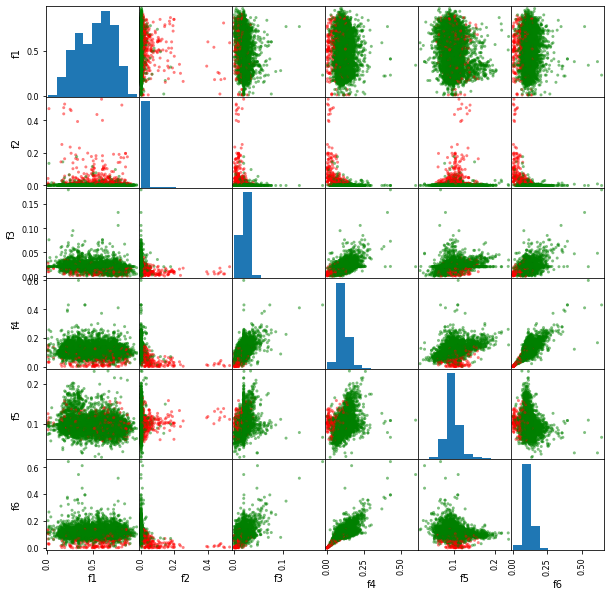

In [11]:
color_code = {'abnormal': 'red',
              'normal'  : 'green'
              }

colors = df['result'].apply(lambda x: color_code[x])

plot = pd.plotting.scatter_matrix(df, c=colors, figsize=(10,10))

Looking at the plot above we can see clearly the difference between abnormal and normal exams in all possible combinations. Except in the following ones f5, f1 and f3, f5.

# 1. Create isolation tree

## 1.1. Random dimension and random split

In [12]:
def pick_random_dimension(df, columns_to_ignore):

  dimensions = [x for x in list(df.columns) if x not in columns_to_ignore]
  
  return dimensions[random.randrange(len(dimensions))]
    

In [13]:
print(pick_random_dimension(df_normal, ['result']))
print(pick_random_dimension(df_normal, ['result']))

f6
f5


In [14]:
def pick_random_split(df, dimension):
    return random.uniform(np.min(df[dimension]), np.max(df[dimension]))
    

In [15]:
print(pick_random_split(df, 'f1'))
print(pick_random_split(df, 'f2'))

0.7677657147575683
0.5208731614277112


## 1.2. Implement split data into two

In [16]:
def split_dataset(df, dimension, split):
  return df[df[dimension]<=split], df[df[dimension]>split]

In [17]:
(left,right) = split_dataset(df, 'f1', 0.4)
print(left.head(5))
print(right.head(5))

      f1       f2     f3     f4     f5     f6  result
1   0.24  0.00025  0.030  0.143  0.133  0.108  normal
4   0.23  0.00025  0.026  0.139  0.090  0.153  normal
11  0.18  0.00010  0.023  0.098  0.085  0.115  normal
15  0.39  0.00010  0.018  0.090  0.071  0.126  normal
16  0.39  0.00060  0.020  0.114  0.100  0.114  normal
     f1       f2     f3     f4     f5     f6  result
0  0.73  0.00060  0.015  0.120  0.082  0.146  normal
2  0.47  0.00190  0.024  0.102  0.131  0.078  normal
3  0.64  0.00090  0.017  0.077  0.090  0.085  normal
5  0.69  0.00025  0.016  0.086  0.070  0.123  normal
6  0.85  0.00025  0.023  0.128  0.104  0.121  normal


## 1.3. Create one isolation tree

In [18]:
# LEAVE AS-IS

dfi = df.copy()
dfi.insert(0, 'id', [("P%.4d" % x) for x in range(1, 1 + len(df))])
dfi

,id,f1,f2,f3,f4,f5,f6,result
0,P0001,0.73,0.00060,0.0150,0.120,0.082,0.1460,normal
1,P0002,0.24,0.00025,0.0300,0.143,0.133,0.1080,normal
2,P0003,0.47,0.00190,0.0240,0.102,0.131,0.0780,normal
3,P0004,0.64,0.00090,0.0170,0.077,0.090,0.0850,normal
4,P0005,0.23,0.00025,0.0260,0.139,0.090,0.1530,normal
...,...,...,...,...,...,...,...,...
7195,P7196,0.59,0.00250,0.0208,0.079,0.099,0.0800,normal
7196,P7197,0.51,0.10600,0.0060,0.005,0.089,0.0055,abnormal
7197,P7198,0.51,0.00076,0.0201,0.090,0.067,0.1340,normal
7198,P7199,0.35,0.00280,0.0201,0.090,0.089,0.1010,normal


In [19]:
def isolation_tree(data, columns_to_ignore, min_items):
  tree = {}
  if len(data) <= min_items:
    return {"contents": data}
  else:
    # REPLACE WITH YOUR CODE
    tree['dimension'] = pick_random_dimension(data, columns_to_ignore)
    tree['split'] = pick_random_split(data, tree['dimension'])


    (left, right) = split_dataset(data, tree['dimension'], tree['split'])

    tree['left']  =  isolation_tree(left, columns_to_ignore, min_items)
    tree['right'] =  isolation_tree(right, columns_to_ignore, min_items)

    return tree  

In [20]:
# LEAVE AS-IS

mytree = isolation_tree(dfi, ['id', 'result'], 2000)

In [21]:
# LEAVE AS-IS

class tree_drawing(object):
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

    def __str__(self, label='', level=0):
        ret = "-" * level + label + ":" + repr(self.value)+"\n"
        if self.left:
            ret += self.left.__str__("<", level+1)
        if self.right:
            ret += self.right.__str__(">", level+1)
        return ret

    def __repr__(self):
        return self.value
    
def tree_to_nodes(tree):
    if 'contents' in tree:
        data = tree['contents']
        normal_count = len(data[data['result'] == 'normal'])
        abnormal_count = len(data[data['result'] == 'abnormal'])
        description = "external node: %d normal + %d abnormal" % (normal_count, abnormal_count)
        return tree_drawing(description)
    else:
        left = tree['left']
        right = tree['right']
        description = 'internal node: ' + tree['dimension'] + ' <= ' + ("%.2f" % tree['split'])
        n = tree_drawing(description, tree_to_nodes(left), tree_to_nodes(right) )
        return n

In [22]:
print(tree_to_nodes(mytree))

:'internal node: f3 <= 0.12'
-<:'internal node: f3 <= 0.02'
--<:'internal node: f6 <= 0.09'
---<:'external node: 1182 normal + 320 abnormal'
--->:'internal node: f5 <= 0.02'
----<:'external node: 2 normal + 0 abnormal'
---->:'internal node: f5 <= 0.12'
-----<:'internal node: f2 <= 0.03'
------<:'internal node: f2 <= 0.00'
-------<:'external node: 1468 normal + 0 abnormal'
------->:'internal node: f5 <= 0.09'
--------<:'external node: 886 normal + 71 abnormal'
-------->:'external node: 1688 normal + 87 abnormal'
------>:'external node: 5 normal + 7 abnormal'
----->:'external node: 181 normal + 8 abnormal'
-->:'external node: 1252 normal + 41 abnormal'
->:'external node: 2 normal + 0 abnormal'



In [23]:
def get_max_tree_depth(tree):
    if not 'left' in tree and not 'right' in tree:
        return 0
    if tree['left']:
        max_left = get_max_tree_depth(tree['left'])
    if tree['right']:
        max_right = get_max_tree_depth(tree['right'])
        
    return max(max_left,max_right) + 1

In [24]:
print(get_max_tree_depth(mytree))

8


# 2. Create isolation forests and find depth of items


## 2.1. Create an isolation forest

In [25]:
def isolation_forest(df, columns_to_ignore, min_items, num_trees):
    return [isolation_tree(df, columns_to_ignore, min_items) for i in range(num_trees)]

In [26]:
myforest = isolation_forest(df, ['id', 'result'], 10, 20)
print(f"The forest has {len(myforest)} trees")

The forest has 20 trees


In [27]:
# MODIFY IF YOU SEE THAT IT IMPROVES THE SEPARATION BETWEEN CLASSES

min_items = 100
num_trees = 30

In [28]:
# LEAVE AS-IS

myforest = isolation_forest(dfi, ['id', 'result'], min_items, num_trees)
print("The forest has %d trees" % len(myforest))

The forest has 30 trees


In [29]:
# Leave this code as-is

for i in range(0, 3):
    print("Tree number %d" % i)
    print(tree_to_nodes(myforest[i]))
    print()

Tree number 0
:'internal node: f4 <= 0.33'
-<:'internal node: f2 <= 0.13'
--<:'internal node: f1 <= 0.68'
---<:'internal node: f4 <= 0.00'
----<:'external node: 0 normal + 9 abnormal'
---->:'internal node: f2 <= 0.07'
-----<:'internal node: f1 <= 0.46'
------<:'internal node: f3 <= 0.07'
-------<:'internal node: f6 <= 0.20'
--------<:'internal node: f4 <= 0.02'
---------<:'external node: 3 normal + 5 abnormal'
--------->:'internal node: f2 <= 0.05'
----------<:'internal node: f5 <= 0.07'
-----------<:'internal node: f5 <= 0.06'
------------<:'external node: 27 normal + 0 abnormal'
------------>:'internal node: f5 <= 0.07'
-------------<:'external node: 81 normal + 4 abnormal'
------------->:'external node: 18 normal + 0 abnormal'
----------->:'internal node: f1 <= 0.23'
------------<:'internal node: f1 <= 0.13'
-------------<:'external node: 36 normal + 8 abnormal'
------------->:'internal node: f2 <= 0.02'
--------------<:'internal node: f5 <= 0.10'
---------------<:'internal node: f4

## 2.2. Find the average depth of an item

In [30]:
# LEAVE AS-IS

def find_element_depth_aux(tree, column_name, column_value, depth):
    
    if 'contents' in tree:
        # We are in a leaf node
        
        data = tree['contents']
        matching = data[data[column_name] == column_value]
        if len(matching) == 0:
            return None
        elif len(matching) > 1:
            print("Error: multiple elements match your search criterion")
            return None
        else:
            return depth
    else:
        # We are in an internal node
        
        in_left = find_element_depth_aux(tree['left'], column_name, column_value, depth+1)
        if in_left == None:
            in_right = find_element_depth_aux(tree['right'], column_name, column_value, depth+1)
            return in_right
        else:
            return in_left
        
def find_element_depth(tree, column_name, column_value):
    return find_element_depth_aux(tree, column_name, column_value, 0)

In [31]:
# LEAVE AS-IS

def print_sample_depths(df, sample_size, tested_tree):

    for result in ['normal', 'abnormal']:
        print("Depths for %s items" % result)

        sample = list(df[df['result'] == result]['id'].sample(sample_size))

        max_depth = get_max_tree_depth(tested_tree)
        for random_id in sample:
            print("- id=%s is at depth %d/%d" % (random_id, find_element_depth(tested_tree, "id", random_id), max_depth))
            
    
print("On shallow tree, having maximum depth %d" % get_max_tree_depth(mytree))
print_sample_depths(dfi, 5, mytree)
print()

print("On first tree of forest, having maximum depth %d" % get_max_tree_depth(myforest[0]))
print_sample_depths(dfi, 5, myforest[0])
print()


On shallow tree, having maximum depth 8
Depths for normal items
- id=P4481 is at depth 3/8
- id=P3701 is at depth 3/8
- id=P1476 is at depth 8/8
- id=P5391 is at depth 8/8
- id=P6411 is at depth 7/8
Depths for abnormal items
- id=P2625 is at depth 8/8
- id=P0116 is at depth 3/8
- id=P1466 is at depth 3/8
- id=P5543 is at depth 3/8
- id=P2137 is at depth 3/8

On first tree of forest, having maximum depth 28
Depths for normal items
- id=P1502 is at depth 20/28
- id=P1067 is at depth 22/28
- id=P5557 is at depth 19/28
- id=P0544 is at depth 25/28
- id=P1666 is at depth 17/28
Depths for abnormal items
- id=P0117 is at depth 9/28
- id=P4998 is at depth 12/28
- id=P5002 is at depth 14/28
- id=P5614 is at depth 4/28
- id=P0773 is at depth 18/28



<font size="+1" color="red">Replace this cell with a brief commentary on these depths.</font>

In [32]:
def find_average_depth(forest, column_name, value):
    sum_depths = 0
    for tree in forest:
        sum_depths += find_element_depth(tree, column_name, value)
        
    average_depth = sum_depths/len(forest)

    return average_depth

In [33]:
# LEAVE AS-IS

for result in ['normal', 'abnormal']:
    print("Average depths for %s items" % result)
    
    sample = list(dfi[dfi['result'] == result]['id'].sample(5))
    
    for random_id in sample:
        print("- id=%s is at average depth %.1f" % (random_id, find_average_depth(myforest, "id", random_id)))
    
    print()

Average depths for normal items
- id=P4402 is at average depth 23.9
- id=P4569 is at average depth 15.6
- id=P3379 is at average depth 20.0
- id=P2260 is at average depth 24.2
- id=P6783 is at average depth 18.6

Average depths for abnormal items
- id=P4396 is at average depth 12.3
- id=P1778 is at average depth 12.8
- id=P2602 is at average depth 7.3
- id=P1628 is at average depth 16.1
- id=P2445 is at average depth 7.7



To make the "find_average_depth" function more efficient. We could perform binary search to find the different depths of the elements. Then the complexity would be O(number of trees x logn) instead of from O(number of trees x n)



# 3. Find the average depth of a sample of normal and abnormal points

## 3.1. Determine average depths

In [34]:
# LEAVE AS-IS

abnormal_point_ids = list(dfi[dfi['result'] == 'abnormal']['id'].sample(50))
normal_point_ids = list(dfi[dfi['result'] == 'normal']['id'].sample(50))

print("Normal point sample ids   : %s" % normal_point_ids)
print("Abnormal point sample ids : %s" % abnormal_point_ids)

Normal point sample ids   : ['P3559', 'P5077', 'P3738', 'P6826', 'P0657', 'P4605', 'P6314', 'P1336', 'P3495', 'P3921', 'P0483', 'P7143', 'P3341', 'P6567', 'P4281', 'P7136', 'P2506', 'P4293', 'P3127', 'P0837', 'P4308', 'P5196', 'P6693', 'P2404', 'P4937', 'P3907', 'P2794', 'P4221', 'P5092', 'P2254', 'P1770', 'P3788', 'P3617', 'P4549', 'P5918', 'P3808', 'P4779', 'P4949', 'P4983', 'P6490', 'P0969', 'P1840', 'P0719', 'P1919', 'P1362', 'P6180', 'P4782', 'P1022', 'P3361', 'P0310']
Abnormal point sample ids : ['P3566', 'P3643', 'P6702', 'P7103', 'P6718', 'P3783', 'P5708', 'P2504', 'P0733', 'P1778', 'P2932', 'P4339', 'P1041', 'P6482', 'P2775', 'P1837', 'P2693', 'P3224', 'P0148', 'P4480', 'P4302', 'P1538', 'P5608', 'P5412', 'P0488', 'P1383', 'P2942', 'P3799', 'P3552', 'P1190', 'P5694', 'P5320', 'P5533', 'P2456', 'P6159', 'P3281', 'P4722', 'P0463', 'P1947', 'P2668', 'P0430', 'P4094', 'P3151', 'P2120', 'P1525', 'P1763', 'P6031', 'P4543', 'P5624', 'P6714']


In [35]:
# LEAVE AS-IS

normal_depths = []
print("Depths of items in the 'normal' sample:")
for i in normal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    normal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'normal' sample:
 element id=P3559 is at average depth 19.90
 element id=P5077 is at average depth 23.90
 element id=P3738 is at average depth 26.03
 element id=P6826 is at average depth 16.60
 element id=P0657 is at average depth 22.87
 element id=P4605 is at average depth 18.43
 element id=P6314 is at average depth 17.63
 element id=P1336 is at average depth 18.80
 element id=P3495 is at average depth 21.10
 element id=P3921 is at average depth 18.47
 element id=P0483 is at average depth 26.07
 element id=P7143 is at average depth 17.83
 element id=P3341 is at average depth 18.03
 element id=P6567 is at average depth 17.17
 element id=P4281 is at average depth 23.03
 element id=P7136 is at average depth 17.73
 element id=P2506 is at average depth 8.50
 element id=P4293 is at average depth 16.50
 element id=P3127 is at average depth 20.37
 element id=P0837 is at average depth 19.50
 element id=P4308 is at average depth 21.57
 element id=P5196 is at average depth

In [36]:
# LEAVE AS-IS

abnormal_depths = []
print("Depths of items in the 'abnormal' sample:")
for i in abnormal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    abnormal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'abnormal' sample:
 element id=P3566 is at average depth 9.90
 element id=P3643 is at average depth 13.40
 element id=P6702 is at average depth 5.83
 element id=P7103 is at average depth 14.83
 element id=P6718 is at average depth 12.63
 element id=P3783 is at average depth 8.10
 element id=P5708 is at average depth 10.03
 element id=P2504 is at average depth 5.10
 element id=P0733 is at average depth 15.57
 element id=P1778 is at average depth 12.83
 element id=P2932 is at average depth 5.57
 element id=P4339 is at average depth 19.37
 element id=P1041 is at average depth 8.20
 element id=P6482 is at average depth 18.50
 element id=P2775 is at average depth 4.93
 element id=P1837 is at average depth 11.17
 element id=P2693 is at average depth 15.13
 element id=P3224 is at average depth 15.03
 element id=P0148 is at average depth 10.00
 element id=P4480 is at average depth 7.60
 element id=P4302 is at average depth 6.73
 element id=P1538 is at average depth 16.73

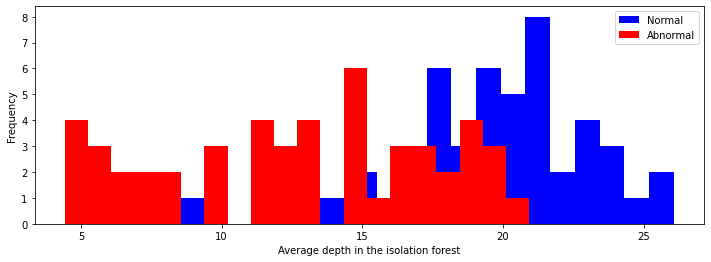

In [37]:
# LEAVE AS-IS

plt.figure(figsize=(12,4))
plt.hist(normal_depths, label='Normal', bins=20, density=False, color='blue')
plt.hist(abnormal_depths, label='Abnormal', bins=20, density=False, color='red')
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The lower mean of abnormal and the higher mean in normal, means that the early leaves we observe in the tree show an abnormal behaviour, whereas for normal, the exams tend to have deeper depth.

## 3.2. Compute outlier scores and conclude

In [38]:
# LEAVE AS-IS

# Source: https://stackoverflow.com/a/27683292/1235784

from numpy import euler_gamma
from scipy.special import digamma
def harmonic(s):
    return digamma(s + 1) + euler_gamma

In [39]:
# LEAVE AS-IS

def outlier_score_factory():
    n = len(df.index)
    c_n = 2.0 * harmonic(n - 1.0) - (2.0 * (n-1)/n)
    return lambda d: 2.0**(-d/c_n)

outlier_score = outlier_score_factory()

normal_scores = [outlier_score(d) for d in normal_depths]
abnormal_scores = [outlier_score(d) for d in abnormal_depths]

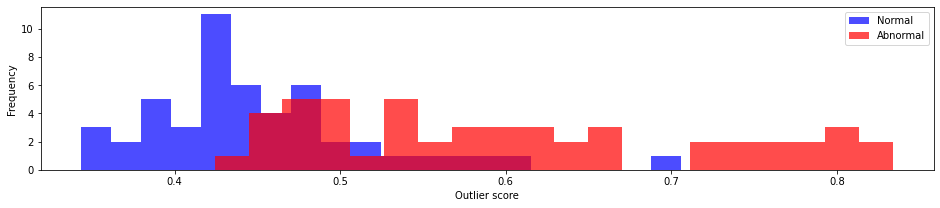

In [40]:
# LEAVE AS-IS

plt.figure(figsize=(16,3))

# Plot the two histograms; the parameter 'alpha' is the transparency of the bar
plt.hist(normal_scores, label='Normal', bins=20, density=False, color='blue', alpha=0.7)
plt.hist(abnormal_scores, label='Abnormal', bins=20, density=False, color='red', alpha=0.7)

# Draw the axis labels, legend, and display
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

We observe that the bigger the outlier score, the more exams fall into the abnormal category. In this histogram, around 0.45 we start to see the outlier scores of abnormal exams. 

In [41]:
# Compute confussion matrix
def confu_matrix(normal_scores, abnormal_scores, threshold):
    confussion_matrix = {
        'false_normal': 0,
        'true_normal' : 0,
        'false_abnormal' : 0,
        'true_abnormal' : 0,
    }

    for score in normal_scores:
      if score < threshold:
        confussion_matrix['true_normal'] += 1
      else:
        confussion_matrix['false_normal'] += 1

    for score in abnormal_scores:
      if score < threshold:
        confussion_matrix['false_abnormal'] += 1
      else:
        confussion_matrix['true_abnormal'] += 1

    return confussion_matrix    

In [42]:
# Compute key stats for ea given confussion matrix using certain threshold

def classification_info(cmat, threshold):

  total = (cmat['true_abnormal'] + cmat['false_normal'] + cmat['true_normal'] + cmat['false_abnormal'])
  true  = (cmat['true_abnormal'] + cmat['true_normal'])
  
  normal = (cmat['true_normal'] + cmat['false_normal'])
  abnormal = (cmat['true_abnormal'] + cmat['false_abnormal'])




  accuracy = true / total
  normal_precision = cmat['true_normal'] / normal
  abnormal_precision = cmat['true_abnormal'] / abnormal
  normal_recall = cmat['true_normal'] / (cmat['true_normal'] + cmat['false_abnormal'])
  abnormal_recall = cmat['true_abnormal'] / (cmat['true_abnormal'] + cmat['false_normal'])
  
  
  print(f"\n-----results for {threshold} outlier threshold-----\n")
  print(f"Accuracy: {round(accuracy, 2)}\n")
  print(f"Normal precision: {round(normal_precision, 2)}")
  print(f"Abnormal precision: {round(abnormal_precision, 2)}")    
  print(f"Recall (TPR): {round(normal_recall, 2)}")
  print(f"Specificity (TNR): {round(abnormal_recall, 2)}")
  print(f"False positive rate (FPR): {round(1- abnormal_recall, 2)}")
  print(f"False negative rate (FNR): {round(1- normal_recall, 2)}")

In [43]:
# Compute possible thresholds
th = [round(0.45 + i*0.01, 2) for i in range(7)]

print(th)

[0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51]


In [44]:
# See performance of different possible thresholds
for t in th:
  confussion_matrix = confu_matrix(normal_scores, abnormal_scores,  t)
  classification_info(confussion_matrix, t)


-----results for 0.45 outlier threshold-----

Accuracy: 0.77

Normal precision: 0.58
Abnormal precision: 0.96
Recall (TPR): 0.94
Specificity (TNR): 0.7
False positive rate (FPR): 0.3
False negative rate (FNR): 0.06

-----results for 0.46 outlier threshold-----

Accuracy: 0.76

Normal precision: 0.62
Abnormal precision: 0.9
Recall (TPR): 0.86
Specificity (TNR): 0.7
False positive rate (FPR): 0.3
False negative rate (FNR): 0.14

-----results for 0.47 outlier threshold-----

Accuracy: 0.76

Normal precision: 0.68
Abnormal precision: 0.84
Recall (TPR): 0.81
Specificity (TNR): 0.72
False positive rate (FPR): 0.28
False negative rate (FNR): 0.19

-----results for 0.48 outlier threshold-----

Accuracy: 0.77

Normal precision: 0.72
Abnormal precision: 0.82
Recall (TPR): 0.8
Specificity (TNR): 0.75
False positive rate (FPR): 0.25
False negative rate (FNR): 0.2

-----results for 0.49 outlier threshold-----

Accuracy: 0.78

Normal precision: 0.8
Abnormal precision: 0.76
Recall (TPR): 0.77
Specif

So, regarding to the theresholds the candidates with best acurracy are:

-----results for 0.48 outlier threshold-----

Accuracy: 0.7

* Normal precision: 0.58
* Abnormal precision: 0.82
* Recall (TPR): 0.76
* Specificity (TNR): 0.66
* False positive rate (FPR): 0.34
* False negative rate (FNR): 0.24

-----results for 0.49 outlier threshold-----

Accuracy: 0.7

* Normal precision: 0.62
* Abnormal precision: 0.78
* Recall (TPR): 0.74
* Specificity (TNR): 0.67
* False positive rate (FPR): 0.33
* False negative rate (FNR): 0.26

But taking into account we are in a medical case I prefer  to have a little less accuracy but higher recall.

This is why I will pick 0.45 as threshold

-----results for 0.45 outlier threshold-----

Accuracy: 0.68

* Normal precision: 0.38
* Abnormal precision: 0.98
* Recall (TPR): 0.95
* Specificity (TNR): 0.61
* False positive rate (FPR): 0.39
* False negative rate (FNR): 0.05

